# BEE 4750 Homework 3: Uncertain Sea-Level Rise and Levee Reliability

**Name**: Akshara Chandrabalan

**ID**: ac2837

> **Due Date**
>
> Friday, 10/06/23, 9:00pm

## Overview

### Instructions

This assignment asks you to conduct a Monte Carlo analysis of levee
reliability in the face of uncertain changes to local sea levels. You
will propagate uncertainty in equilibrium climate sensitivity through
the energy balance model to obtain a distribution of temperatures, which
will then drive a model of sea-level rise. You will finally use this
distribution to assess the probability that a planned levee will achieve
its desired reliability standard.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Documents/BEE 5750 /hw3-akshara-c`


In [19]:
using Random
using Plots
using LaTeXStrings
using Distributions
using CSV
using DataFrames


## Problems (Total: 40 Points)

### Problem 1 (12 points)

Recall from class that the simple energy balance model (EBM) of
planetary energy balance links changes in radiative forcing ($F$) to
global mean temperature ($T$) changes through the discretized equation
$$T_{i+1} = T_{i} + \frac{F_i - \lambda T_i}{cd} \times \Delta t,$$
where $i$ is the current time step, $c = 4.184 \times 10^6$
J/K/m<sup>2</sup> is the heat capacity of water per unit area, $d$ is
the (uncertain) depth of the mixing layer, $\Delta t$ is the annual time
step in seconds and $\lambda = F_{\text{2xCO}_2}/S$ is the climate
feedback parameter in W/m<sup>2</sup>/$^\circ$ C, where $S$ is the
equilibrium climate sensitivity (the uncertain equilibrium temperature
change resulting from a doubling of atmospheric CO<sub>2</sub>).
Finally, while total radiative forcing can be the result of non-aerosol
and aerosol effects, we do not know the relative intensity of aerosol
forcing, so we represent this with an uncertain aerosol scaling factor
$\alpha$.

We can implement this model with the following Julia function. We will
assume an ocean mixing depth $d = 100$ m and an aerosol scaling factor
$\alpha = 1.3$ so we can focus on the uncertainty in $S$.

The last technical concern is that “global mean temperature” does not
make sense in absolute terms as a marker of climate change. Instead, we
typically refer to temperature changes relative to some historical
pre-industrial baseline. In this case, we will use the period from
1880-1900, though this choice can vary.

In [3]:
# we need to split up the aerosol and non-aerosol forcings when we call the function
function energy_balance_model(S, forcing_aerosol, forcing_non_aerosol)
    d = 100 # ocean mixing depth [m]
    α = 1.3 # aerosol scaling factor
    F2xCO₂ = 4.0 # radiative forcing [W/m²] for a doubling of CO₂
    λ = F2xCO₂/S
    
    c = 4.184e6 # heat capacity/area [J/K/m²]
    C = c*d # heat capacity of mixed layer (per area)

    F = forcing_non_aerosol + α*forcing_aerosol # radiative forcing

    Δt = 31558152.0 # annual timestep [s]
    
    T = zeros(length(F))
    for i in 1:length(F)-1
        T[i+1] = T[i] + (F[i] - λ*T[i])/C * Δt
    end
    # return temperature anomaly relative to 1880-1900 baseline
    return T .- mean(T[1:21]) 
end

energy_balance_model (generic function with 1 method)

Finally, we need to load some radiative forcing data. We will use the
radiative forcing scenario RCP 8.5. We can load this data, which is in a
`.csv` (comma-delimited) file, into a `DataFrame`, which is a tabular
data structure. Rows and columns in a `DataFrame` can be accessed using
their numerical index (like a matrix), but columns also have names; you
can access a particular column in a dataframe `df` by name using
`df.colname` or `df[:, "colname"]`.

Of note: this data set goes from 1750–2500, so you will need to take
care to make sure you are using the right years at each step. For
example, here we will constrain the data to 1880–2100, which is the
period we are interested in.

In [4]:
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
forcings_all_85 = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# get the years corresponding to the forcings
t = Int64.(forcings_all_85[!,"year"]) # Ensure that years are interpreted as integers
# find the indices of the years 1880 and 2100
# we can do this with the indexin function
time_bounds = indexin([1880, 2100], t) # returns a 2 element vector
years = time_bounds[1]:time_bounds[2] # create range of years

# Separate out the individual components
forcing_co2_85 = forcings_all_85[years,"co2"]
# Get total aerosol and non-aerosol forcings
forcing_aerosol_rad_85 = forcings_all_85[years,"aerosol-radiation_interactions"]
forcing_aerosol_cloud_85 = forcings_all_85[years,"aerosol-cloud_interactions"]
forcing_aerosol_85 = forcing_aerosol_rad_85 + forcing_aerosol_cloud_85 # aerosol forcings
forcing_total_85 = forcings_all_85[years,"total"] 
forcing_non_aerosol_85 = forcing_total_85 - forcing_aerosol_85 # non-aerosol forcings

221-element Vector{Float64}:
  0.42741479112315905
  0.4487940147601447
  0.4900144276528058
 -0.019811270078689047
 -1.480725700367619
 -0.3154905163510021
  0.233186559774844
  0.2923308952663089
  0.45833872365810924
  0.5168189581089915
  ⋮
  9.879065698371564
  9.946850640754889
 10.002169546141578
 10.061009359425011
 10.115684195707905
 10.182946497594184
 10.249699157847772
 10.331407709334023
 10.424544495740134

For this assignment, you can use the `forcing_aerosol_85` and
`forcing_non_aerosol_85` vectors as is to correspond to the relevant
forcings. You will need to use the vector `t` to find the appropriate
years for analysis.

#### Problem 1.1 (3 points) 

Assume that $S$ is distributed according to
$\text{LogNormal}(\log(3.2), \log{2}/3)$ (as in class). Draw 10,000
samples from this distribution and make a histogram.

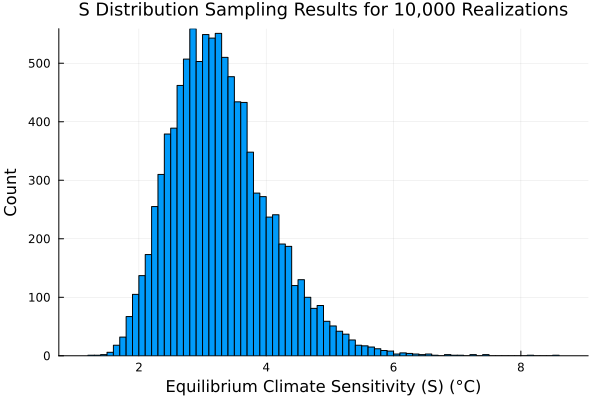

In [5]:
Random.seed!(1)

S_dist = LogNormal(log(3.2),log(2)/3)
S = rand(S_dist,10000) # selects 10,000 S values from the distribution randomly

histogram(S, legend = false)
xlabel!("Equilibrium Climate Sensitivity (S) (°C)")
ylabel!("Count")
title!("S Distribution Sampling Results for 10,000 Realizations", titlefont = font(12))


#### Problem 1.2 (5 points) 

Use the EBM to propagate your samples of $S$ to a distribution of global
mean temperature. Plot the median and 90% predictive distribution
(between the .05 and .95 quantiles) from 1880-2100.

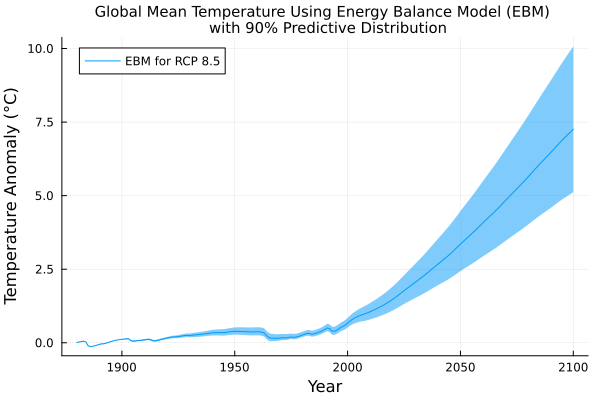

In [6]:
temp_anom = Array{Float64}(undef,0) # initializing an empty, mutable array to store temp values 
for i = 1:length(S)
    temp_change = energy_balance_model(S[i], forcing_aerosol_85, forcing_non_aerosol_85) # output is a column vector where each element is temp for every year in the range based on S[i]
    temp_change = temp_change' # changing to a row vector
    temp_anom = cat(temp_anom, temp_change, dims = 1) # rows corresponds to S values, col corresponds to year, so each element is the temp for a given year with respect to a specifc S value
end
return temp_anom

temp_median = quantile.(eachcol(temp_anom), 0.5) # computing median temp value for every year from 1880-2100
years = collect(1880:2100)

lower_quantile = quantile.(eachcol(temp_anom), 0.05) # computing lower uncertainty interval  
upper_quantile = quantile.(eachcol(temp_anom), 0.95) # computing upper uncertainty interval    

plot(years, temp_median, label = "EBM for RCP 8.5", legend=:topleft, 
    ribbon = (temp_median - lower_quantile, upper_quantile - temp_median))
xlabel!("Year")
ylabel!("Temperature Anomaly (°C)")
title!("Global Mean Temperature Using Energy Balance Model (EBM) \n with 90% Predictive Distribution", titlefont = font(10))


#### Problem 1.3 (4 points) 

Make a histogram of global mean temperature projections in 2100. If you
compare this distribution to the distribution of $S$ from Problem 1.1,
what do you observe?

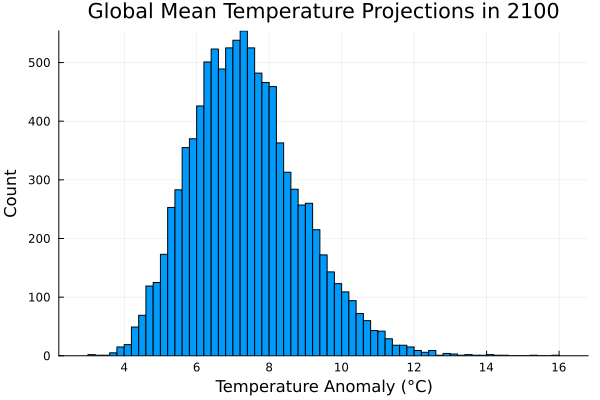

In [7]:
temp_anom_2100 = temp_anom[:, 221] # taking all the temp values in column 221, which corresponds to the year 2100

histogram(temp_anom_2100, legend = false)
xlabel!("Temperature Anomaly (°C)")
ylabel!("Count")
title!("Global Mean Temperature Projections in 2100")


ANSWER: The distributions follow a similar overall shape, which is expected because global mean temp is a function of S, however, the distribution of global mean temp is wider/more spread out than the distribution of S. S in 1.1 varies from approximately 1 to 7, whereas global mean temp in this example varies from roughly 3 to 14. There is a larger variation in global mean temp because the uncertainty in S is propogated through the calculation of global mean temp.

### Problem 2 (15 points)

Changes to global temperatures cause changes in global sea levels
through several mechanisms, including thermal expansion (the change in
ocean volume due to increased heat content) and melting land-based ice.
One simple way to represent this link is through the following model,
proposed by [Rahmstorf (2007)](https://doi.org/10.1126/science.1135456).

$$\frac{dH}{dt} = a(T-T_0),$$

where $H$ is the global mean sea level in mm, $T$ is global mean
temperature, $T_0$ is an equilibrium temperature (where there is no
change in sea levels), and $a$ is a proportionality constant. This model
can be discretized to give $$H_{i+1} - H_i = a (T_i - T_0).$$

Note that, like with global mean temperature, the notion of “global mean
sea level” does not make sense in absolute terms (were sea levels ever
at “zero”?). Instead, we want to normalize this relative to some
historical baseline. In this case (with a view towards Problem 3), we
will compute our sea levels relative to the 2010 sea level. Note that in
addition to the model parameters, we also need an initial sea-level
parameter $H_0$ which will give us the right anomaly level.

The best estimates for these parameters are:

-   $a = 1.86$;
-   $H_0 = -223$;
-   $T_0 = -0.62$

#### Problem 2.1 (5 points) 

Write a function `sea_level_model()` to implement the mathematical
sea-level rise model described above. It should take in needed
parameters and a vector of temperatures and return a vector of sea
levels. To test your function, use the provided temperature series
`historical_temps` (read in below) to compute the global mean sea level
anomaly in 2022 (the last year of the dataset) with the parameter values
above; you should get a value of approximately 40mm.

In [8]:
historical_temp_data = CSV.read("data/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv", DataFrame, delim=",")
# column 2 is the temperature anomaly, column 1 is the year
temp_bds = indexin([1880, 1900], historical_temp_data[!, 1]) # find the index of 2010 for normalization
historical_temp_data[:, 2] .-= mean(historical_temp_data[temp_bds[1]:temp_bds[2], 2])
historical_temps = historical_temp_data[temp_bds[1]:end, 2]

143-element Vector{Float64}:
  0.07297116761904765
  0.15655772761904765
  0.09327316761904769
  0.04232884761904765
 -0.10351681238095234
 -0.08232033238095232
 -0.03210037238095231
 -0.10998251238095236
  0.00942435761904764
  0.13890768761904768
  ⋮
  1.0616748976190478
  1.2139176176190476
  1.3217303776190477
  1.2339774976190476
  1.1514572476190477
  1.2798758476190477
  1.3115970476190477
  1.1506591476190478
  1.1896871476190476

In [9]:
function sea_level_model(α, H0, T0, temp_series)
    H = zeros(length(temp_series)) # initializing column vector to store sea level values
    H[1] = H0 # setting initial sea level
    for i in 1:length(temp_series)-1
        H[i+1] = H[i] + α *(temp_series[i] - T0)
    end
    return H .- H[131] # sea level anomaly relative to 2010 baseline
end

sea_level = sea_level_model(1.86, -223, -0.62, historical_temps)
sea_level_2022 = round(sea_level[143], digits = 0)
print("global mean sea level anomaly in 2022 (in mm): ", sea_level_2022)

global mean sea level anomaly in 2022 (in mm): 39.0

#### Problem 2.2 (5 points)

Evaluate `sea_level_model()` using the projected temperature ensemble
from Problem 1. Plot the 90% projection interval of the sea levels.

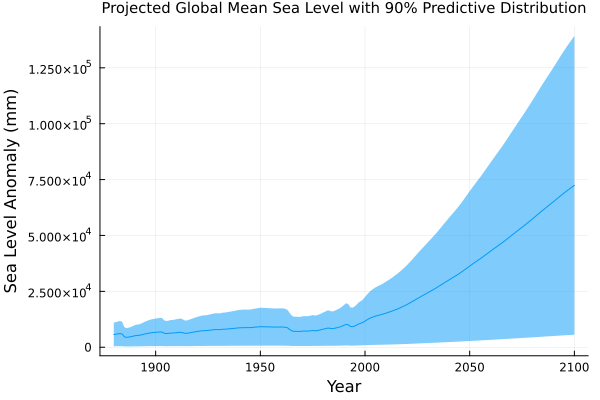

In [12]:
years = collect(1880:2100)
sea_lvl_anom = Array{Float64}(undef, 10000, 221) # initializing 10000x221 matrix (same dim as temp matrix) to store computed sea lvl values

for i = 1:length(years) # for each year, using corresponding temp values from temp_anom matrix to calculate sea levels for that year
    sea_lvl_change = sea_level_model(1.86, -223, -0.62, temp_anom[:, i]) 
    sea_lvl_anom[:, i] = sea_lvl_change
end
return sea_lvl_anom

sea_lvl_median = quantile.(eachcol(sea_lvl_anom), 0.5) 

lower_quantile = quantile.(eachcol(sea_lvl_anom), 0.05)  
upper_quantile = quantile.(eachcol(sea_lvl_anom), 0.95)    

plot(years, sea_lvl_median, legend=false, 
    ribbon = (sea_lvl_median - lower_quantile, upper_quantile - sea_lvl_median))
xlabel!("Year")
ylabel!("Sea Level Anomaly (mm)")
title!("Projected Global Mean Sea Level with 90% Predictive Distribution", titlefont = font(10))

NOTE: Not sure why I am getting such large values for sea level anomaly, I tested everyhting individually up until computing the sea level change in the for loop and everything was wokring as expected. This is the logic I followed: 
1. We have a temp anomaly matrix 10000x221 (from problem 1)
2. Initialize a sea level matrix with dimensions 10000x221
3. The goal of the for loop is to compute 10000 sea level values for each year (221 years in total)
4. In a for loop, we iterate from 1:221 and each iteration uses a column of values from the temp anomaly matrix to compute the values for sea level that year
5. The for loop returns a 10000x221 matrix of sea level values for 1880-2100
6. Apply the quantile and median operations (as in 1.2) to the sea level matrix

In [13]:
# testing to try and debug issue
temp_anom[:,1]

10000-element Vector{Float64}:
 0.01000082209730457
 0.0124310956739767
 0.0070363798311793065
 0.01972402557312872
 0.014937769973593409
 0.011368834345895557
 0.01717011054875021
 0.006960133404627858
 0.006103577612646553
 0.00895456139591094
 ⋮
 0.014391415203401687
 0.010783105670960136
 0.009877057041713605
 0.009870823854865549
 0.01728073927984392
 0.006636130438959376
 0.0056821005954422995
 0.011904231368808254
 0.00993920267854099

In [14]:
# testing to try and debug issue
sea_lvl_change = sea_level_model(1.86, -223, -0.62, temp_anom[:, 1]) 


10000-element Vector{Float64}:
  -152.39394968500002
  -151.22214815589905
  -150.04582631794545
  -148.87953865145946
  -147.68965196389343
  -146.50866771174253
  -145.33432167985916
  -144.14918527423848
  -142.98303942610588
  -141.81848677174636
     ⋮
 11559.999590564563
 11561.179558596841
 11562.35281517339
 11563.524386499488
 11564.69594623186
 11565.88128840692
 11567.046831609536
 11568.210600316643
 11569.38594218699

In [50]:
# testing to see what the values of the sea level matrix are using temp projections from problem 1
years = collect(1880:2100)
sea_lvl_anom = Array{Float64}(undef, 10000, 221)

for i = 1:length(years)
    sea_lvl_change = sea_level_model(1.86, -223, -0.62, temp_anom[:, i]) 
    sea_lvl_anom[:, i] = sea_lvl_change
end
return sea_lvl_anom

# ISSUE: values look too big to be right

10000×221 Matrix{Float64}:
  -152.394   -155.922   -159.431  …   -1917.79        -1936.21
  -151.222   -154.723   -158.205      -1903.47        -1921.76
  -150.046   -153.519   -156.974      -1887.44        -1905.57
  -148.88    -152.326   -155.754      -1874.99        -1893.0
  -147.69    -151.109   -154.509      -1852.35        -1870.12
  -146.509   -149.901   -153.273  …   -1834.34        -1851.93
  -145.334   -148.699   -152.044      -1819.08        -1836.52
  -144.149   -147.487   -150.804      -1799.08        -1816.31
  -142.983   -146.294   -149.584      -1786.66        -1803.78
  -141.818   -145.102   -148.366      -1774.75        -1791.77
     ⋮                            ⋱                       ⋮
 11560.0    11827.6    12093.9            1.4522e5        1.46612e5
 11561.2    11828.8    12095.2            1.45237e5       1.4663e5
 11562.4    11830.0    12096.4            1.45252e5       1.46645e5
 11563.5    11831.2    12097.6            1.45266e5       1.46659e5
 11564.7    1

#### Problem 2.3 (5 points) 

Make a histogram of the sea-level anomaly in 2100. What can you observe
about how the ECS uncertainty has impacted sea-level uncertainty under
this radiative forcing scenario? What might the implications be of only
using the best-estimate ECS value?

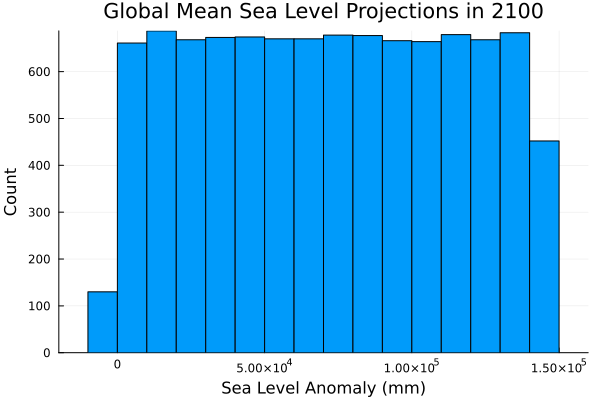

In [53]:
sea_lvl_anom_2100 = sea_lvl_anom[:, 221] # taking all the sea level values in column 221, which corresponds to the year 2100

histogram(sea_lvl_anom_2100, legend = false)
xlabel!("Sea Level Anomaly (mm)")
ylabel!("Count")
title!("Global Mean Sea Level Projections in 2100")


Note: Distribution is not correct due to carry over error from problem 1.2.

ANSWER (assuming the distribution was correct and followed a bell shape curve): ECS uncertainty propogation has resulted in an even wider spread/distribution of values for sea level anomaly (larger uncertainty). After about 2000, the uncertainties get drastically larger, with the largest uncertainty being for 2100. In other words, there is more uncertainty spread going forward in time than historically (hindcast) because of the larger radiative forcing change, which has a more significant effect on λ, and thus, also on the sensitivity of the predictions. If only the best-estimate ECS value was used, uncertainty in the both global tem and sea level anomaly is not being considered. Thus, the results may capture the overall trend of the actual temp and sea level data, but not the specific values as the model is more suceptible to under or over-estimating. Additionally, using only the best-estimate ECS value would mean we're not quantifying the impact of upstream uncertainties on system outputs, which means our model is not as comprehensive for different radiative forcing scenerios. 

### Problem 3 (13 points)

You’ve been asked to consult on a levee reliability analysis. For
context, levees in the United States are supposed to only fail once in
100 years, or, in other words, to have at most a 1% chance of failure in
a given year. We will assume for this problem that the only way in which
a levee fails is by being overtopped (note: this is unrealistic).

We can assess the probability of levee overtopping by comparing its
height to a distribution of extreme sea levels. A common approach is to
look at the distribution of the highest sea level each year. These
extreme sea levels can be obtained by combining the absolute sea level
(we will use our distribution of global sea levels for this), the rate
of subsidence (how much the ground sinks), and the distribution of storm
tides (the highest tide level, which is often the result of storm surges
combining with high tide).

Assume for this problem that:

1.  the annual rate of subsidence $\nu$ is 1.2mm/yr;
2.  the distribution of annual storm tide maxima, above the mean sea
    level, is (and is expected to continue to be) given by a
    $\text{GeneralizedExtremeValue}(900, 25, 0.3)$ distribution, which
    looks like this:

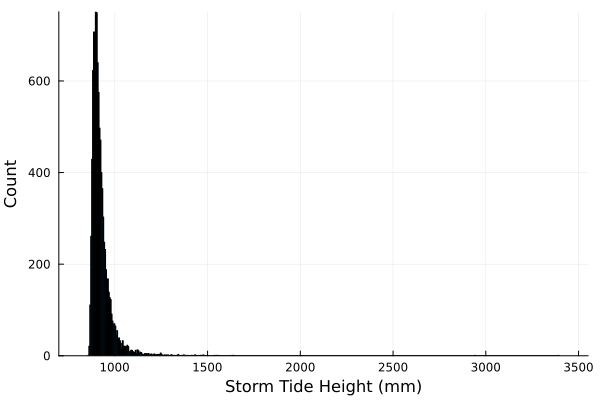

In [47]:
tide_distribution = GeneralizedExtremeValue(900, 25, 0.3)
histogram(rand(tide_distribution, 10000), xlabel="Storm Tide Height (mm)", ylabel="Count", legend=:false)

Feel free to just sample from `tide_distribution` in your solution
below.

#### Problem 3.1 (2 points)

How would you use your sea-level simulations and the above information
to compute a distribution of extreme sea levels in 2100 relative to 2010
mean sea level? Write down the approach in clear steps, with equations
as needed.

ANSWER: 
1. Extreme sea level (mm) = abs sea level (mm) + rate of subsidence (mm/yr) + high tide (mm)
    - need to multiply $\nu$ by the number of years of interest (in our case 2010-2100, so t = (2100-2010)+1 = 91) so units for extreme 
    sea level work out to mm
3. Draw 10,000 samples from storm tide distribution (to match the 10,000 abs sea level values we have for 2100)
2. Using above eq in step 1, and values from step 2, use for loop to iterate through sea level values for 2100 and compute extreme sea level
4. Plot histogram 

#### Problem 3.2 (3 points)

Follow the steps above and produce a histogram of the extreme sea levels
in 2100 relative to 2010.

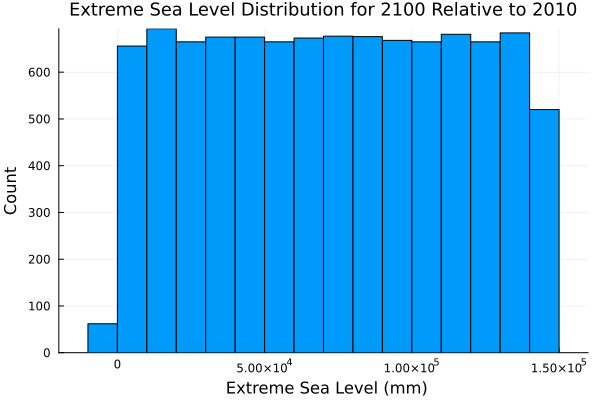

In [48]:
vt = 1.2 * 91 # subsidence (mm) for given time frame

storm_tide = rand(tide_distribution, 10000) # storm tide values from distribution 

ext_sea_lvl_2100 = []
for i = 1:length(storm_tide) # computing ext sea level based on eq in step 1
    ext_sea_lvl_val = sea_lvl_anom_2100[i] + vt + storm_tide[i]
    append!(ext_sea_lvl_2100, ext_sea_lvl_val)
end
return ext_sea_lvl_2100

histogram(ext_sea_lvl_2100, legend = false)
xlabel!(" Extreme Sea Level (mm)")
ylabel!("Count")
title!("Extreme Sea Level Distribution for 2100 Relative to 2010", titlefont=font(12))


NOTE: Histogram does not look as it should due to carry over error from problem 2.2. Should have a similar shape to storm tide distribution.

#### Problem 3.3 (5 points)

The current levee was heightened in 2010 to 2m above the 2010 mean sea level. Based on your analysis above, what is the probability that the levee will be overtopped in 2100 (remember that the reliability standard is 1%)?

In [56]:
h_levee = 2000 # levee height in mm

count = 0
for i = 1:length(ext_sea_lvl_2100)
    if ext_sea_lvl_2100[i] > h_levee # checking if ext sea level value is greater than levee height
        count += 1
    end
end
return count

prob = (count/10000) * 100

98.06

ANSWER: 98.06%
NOTE: Probability is much higher than it should be because of carry over error. 

#### Problem 3.4 (3 points)

Based on your analysis, would you recommend that the levee be heightened
again in the future, and if so, how high? What other information might
you need, if any, to make your recommendation?

ANSWER: Yes, because probability of exceedence is greater than 1% for the year 2100, so the relaibility standard of 1% for any given year is not met. The hieght the levee should be extended to depends on how accurate we make our sea level projections, as that will affect how accurate the approporiate levee height will be. Additionally, the area where the levee will be implemented affects the decision as well. For example, high-risk area, we want to be more conservative for the levee height.  

## References

List any external references consulted, including classmates.

GeeksforGeeks. (n.d.). *Initializing Arrays and Matrices*. https://www.geeksforgeeks.org/concatenation-of-arrays-in-julia-cat-vcat-hcat-and-hvcat-methods/

Julia Documentation. (n.d.). *Arrays Constructors and Types*. https://docs.julialang.org/en/v1/base/arrays/#Base.zeros

Julia Documentation. (n.d.). *Histograms*. https://docs.juliaplots.org/latest/series_types/histogram/

MatecDev. (2021, November 5). *Initializing Arrays and Matrices*. https://www.matecdev.com/posts/julia-array-initialize.html#:~:text=Empty%20Arrays,-Empty%20arrays%20can&text=To%20initialize%20an%20empty%20array,0%20in%20the%20above%20expressions.&text=v%20%3D%20%5B%5D%20%23%20Same%20as,type%20easily%20later%20(gotcha!)

Maths UNSW Sydney. (n.d.). *MATLAB Lesson 3 - Vectors*. https://www.maths.unsw.edu.au/sites/default/files/MatlabSelfPaced/lesson3/MatlabLesson3_ColumnVectors.html#:~:text=in%20Lesson%205.-,Transpose,operator%20'%20(an%20apostrophe).

Srikrishnan, V. (2023). *Lecture 12: Uncertainty and Simple Climate Models*. BEE 4750/5750 Environmental Systems Analysis. https://viveks.me/environmental-systems-analysis/slides/lecture05-3.html#/title-slide

**https://discourse.julialang.org/t/how-to-specify-text-in-plots-font-family-font-size-etc/60311

Consulted with Christine Swanson